In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [143]:
pd.set_option('display.max_columns', None)

games1 = pd.read_csv('data/games2024.csv')
games2 = pd.read_csv('data/games2025.csv')
games = pd.concat([games1, games2], ignore_index=True)

In [144]:
df1 = pd.read_csv('data/plays2024.csv')
data1 = df1[['gameId', 'quarter', 'down', 'yardsToGo', 'gameClock', 'absoluteYardlineNumber', 'possessionTeam', 'defensiveTeam', 'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability']]#, 'receiverAlignment'
result1 = df1['passResult']

df2 = pd.read_csv('data/plays2025.csv')
data2 = df2[['gameId', 'quarter', 'down', 'yardsToGo', 'gameClock', 'absoluteYardlineNumber', 'possessionTeam', 'defensiveTeam', 'preSnapHomeScore', 'preSnapVisitorScore', 'offenseFormation', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability']]#, 'receiverAlignment'
result2 = df2['passResult']

data = pd.concat([data1, data2], ignore_index=True)
result = pd.concat([result1, result2], ignore_index=True).tolist()

In [71]:
data.head()

,gameId,quarter,down,yardsToGo,gameClock,absoluteYardlineNumber,possessionTeam,defensiveTeam,preSnapHomeScore,preSnapVisitorScore,offenseFormation,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability
0,2022100908,4,1,10,7:52,69,ATL,TB,21,7,SHOTGUN,0.976785,0.023215
1,2022091103,4,1,10,7:38,76,PIT,CIN,14,20,SHOTGUN,0.160485,0.839515
2,2022091111,2,2,5,8:57,40,LV,LAC,10,3,I_FORM,0.756661,0.243339
3,2022100212,3,2,10,13:12,47,DEN,LV,19,16,SINGLEBACK,0.620552,0.379448
4,2022091900,2,1,10,8:33,75,BUF,TEN,7,7,I_FORM,0.836290,0.163710


In [72]:
data['winProbabilityDiff'] = data['preSnapHomeTeamWinProbability'] - data['preSnapVisitorTeamWinProbability']
data = data.drop(['preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability'], axis=1)

In [73]:
times = []
#yards = []
possessionScore = []
defenceScore = []
pointDiff = []
for i in range(len(data)):
    if data['quarter'][i] == 1 or data['quarter'][i] == 3:
        additional = 15 * 60
    else:
        additional = 0
    #print(df['gameClock'][i])
    time = data['gameClock'][i].split(':')
    times.append(additional + int(time[0]) * 60 + int(time[1]))

    #yard = df['yardlineNumber'][i]
    #if df['yardlineSide'][i] == df['possessionTeam'][i]:
    #    yard = 100 - int(yard)
    #yards.append(yard)

    gameid = data['gameId'][i]
    pos = data['possessionTeam'][i]
    defence = data['defensiveTeam'][i]
    row = games[games['gameId'] == gameid]
    if pos == row.iloc[0]['homeTeamAbbr']:
        possessionScore.append(data['preSnapHomeScore'][i])
        defenceScore.append(data['preSnapVisitorScore'][i])
        pointDiff.append(data['preSnapHomeScore'][i] - data['preSnapVisitorScore'][i])
    else:
        possessionScore.append(data['preSnapVisitorScore'][i])
        defenceScore.append(data['preSnapHomeScore'][i])
        pointDiff.append(data['preSnapVisitorScore'][i] - data['preSnapHomeScore'][i])

In [74]:
data['timeLeftHalf'] = times
#data['yardsToGoal'] = yards
#data['possessionScore'] = possessionScore
#data['defenceScore'] = defenceScore
data['pointDifferential'] = pointDiff

data = data.drop(['gameClock', 'gameId', 'preSnapHomeScore', 'preSnapVisitorScore'], axis=1)
label_encoder = LabelEncoder()
data['possessionTeam'] = label_encoder.fit_transform(data['possessionTeam'])
data['defensiveTeam'] = label_encoder.fit_transform(data['defensiveTeam'])
data['offenseFormation'] = label_encoder.fit_transform(data['offenseFormation'])
#data['receiverAlignment'] = label_encoder.fit_transform(data['receiverAlignment'])

# 0 for pass 1 for run
target = [0 if type(i) == type("") else 1 for i in result]

print(data[:10])
print(result[:10])
print(target[:10])

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

   quarter  down  yardsToGo  absoluteYardlineNumber  possessionTeam  \
0        4     1         10                      69               1   
1        4     1         10                      76              26   
2        2     2          5                      40              18   
3        3     2         10                      47               9   
4        2     1         10                      75               3   
5        3     3         17                      28               1   
6        4     3          5                      85              30   
7        1     1         10                      85              28   
8        2     1         10                      70              15   
9        3     1         10                      85              27   

   defensiveTeam  offenseFormation  winProbabilityDiff  timeLeftHalf  \
0             29                 4            0.953569           472   
1              6                 4           -0.679031           458   
2 

In [ ]:
# Logistic Regression (Baseline)
# Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
logr = LogisticRegression(max_iter=1000, C=0.1, penalty='l1', solver='liblinear')
logr.fit(X_train, y_train)

# Evaluate model
y_pred = logr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)

Logistic Regression Accuracy: 0.6564138413142258
Confusion Matrix:
[[3327 1456]
 [1493 2307]]


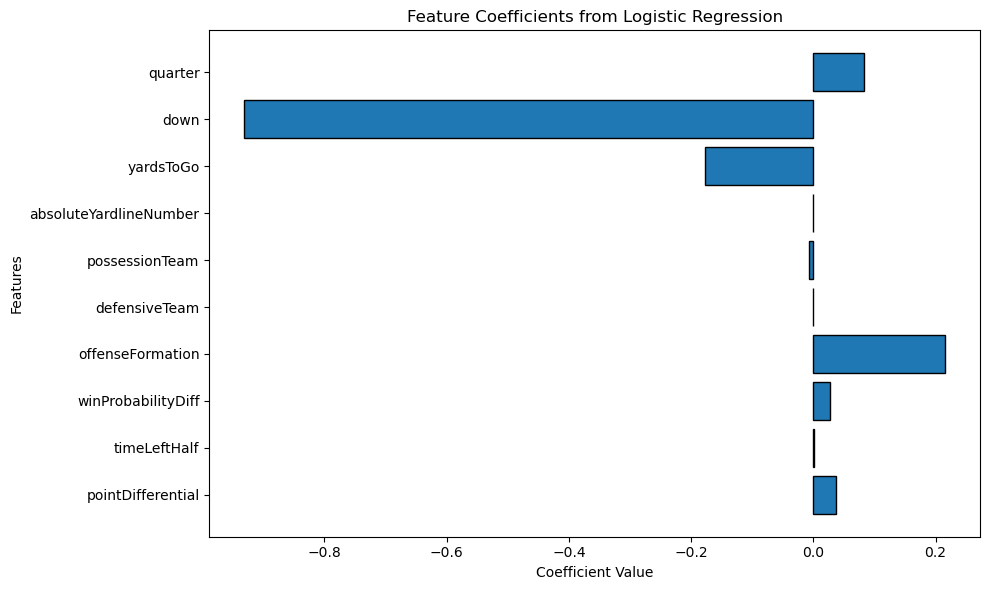

In [ ]:
# Extract feature importance (coefficients)
coefficients = logr.coef_[0]
features = X_train.columns

# Create a bar chart for feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, edgecolor='k')
plt.title('Feature Coefficients from Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # To display most important feature at the top
plt.tight_layout()
plt.show()

In [139]:
# Random Forest
rf = RandomForestClassifier(n_estimators=150, max_depth=25, random_state=42) # Best model: 89.0% n_estimators=150, max_depth=25, random_state=42
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.8886170336712106
Confusion Matrix:
[[4188  595]
 [ 361 3439]]


In [77]:

indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred))]

print("\nTotal distribution of downs:")
downs = {1: 0, 2: 0, 3: 0, 4: 0}
for idx in indices:
    #print(f"Index: {idx}, True label: {y_test[idx]}, Predicted label: {y_pred[idx]}")
    #print(f"Features: {X_test.iloc[idx].to_dict()}")
    downs[X_test.iloc[idx].to_dict()['down']] += 1

print(downs)
print(f"1st: {downs[1]/len(indices)}, 2nd: {downs[2]/len(indices)}, 3rd: {downs[3]/len(indices)}, 4th: {downs[4]/len(indices)}")

misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

print("\nIncorrectly classified downs:")
mis_downs = {1: 0, 2: 0, 3: 0, 4: 0}
for idx in misclassified_indices:
    #print(f"Index: {idx}, True label: {y_test[idx]}, Predicted label: {y_pred[idx]}")
    #print(f"Features: {X_test.iloc[idx].to_dict()}")
    mis_downs[X_test.iloc[idx].to_dict()['down']] += 1

print(mis_downs)
print(f"1st: {mis_downs[1]/len(misclassified_indices)}, 2nd: {mis_downs[2]/len(misclassified_indices)}, 3rd: {mis_downs[3]/len(misclassified_indices)}, 4th: {mis_downs[4]/len(misclassified_indices)}")
print(f"Accuracy by down:\n1st: {(downs[1] - mis_downs[1])/downs[1]}, 2nd: {(downs[2] - mis_downs[2])/downs[2]}, 3rd: {(downs[3] - mis_downs[3])/downs[3]}, 4th: {(downs[4] - mis_downs[4])/downs[4]}")

print(f"Features: {X_train.columns}")
print(f"Importances: {rf.feature_importances_}")


Total distribution of downs:
{1: 3902, 2: 2864, 3: 1670, 4: 147}
1st: 0.45461959687754866, 2nd: 0.33368286147034837, 3rd: 0.19457066293836653, 4th: 0.017126878713736457

Incorrectly classified downs:
{1: 546, 2: 305, 3: 90, 4: 15}
1st: 0.5711297071129707, 2nd: 0.3190376569037657, 3rd: 0.09414225941422594, 4th: 0.015690376569037656
Accuracy by down:
1st: 0.8600717580727832, 2nd: 0.8935055865921788, 3rd: 0.9461077844311377, 4th: 0.8979591836734694
Features: Index(['quarter', 'down', 'yardsToGo', 'absoluteYardlineNumber',
       'possessionTeam', 'defensiveTeam', 'offenseFormation',
       'winProbabilityDiff', 'timeLeftHalf', 'pointDifferential'],
      dtype='object')
Importances: [0.03122147 0.05248793 0.09193159 0.11838784 0.08560234 0.08164643
 0.17212848 0.13603164 0.14798067 0.0825816 ]


In [78]:
k_folds = KFold(n_splits=10)

scores = cross_val_score(rf, X_train, y_train, cv=k_folds) 

print(f"CV Scores: {scores}")

CV Scores: [0.86120819 0.87818273 0.86470295 0.87718422 0.87269096 0.85921118
 0.87319021 0.88911089 0.87262737 0.87362637]


In [ ]:

# Train a Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=29, random_state=42)
dt.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Confusion Matrix:")
print(cm_dt)

Decision Tree Accuracy: 0.8665967610392636
Decision Tree Confusion Matrix:
[[4089  694]
 [ 451 3349]]


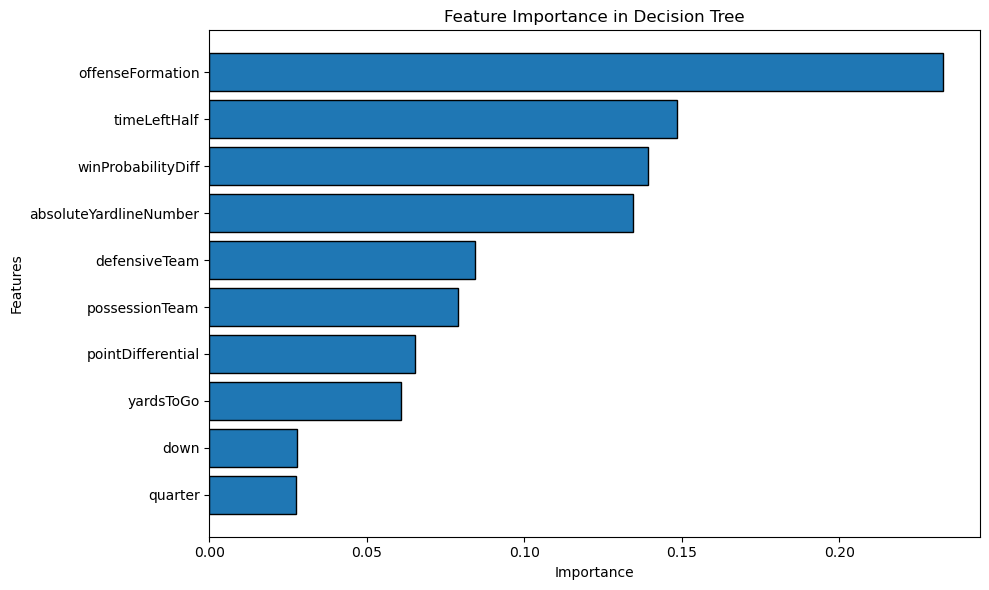

In [ ]:

# Assuming `dt` is the trained DecisionTreeClassifier
feature_importance = dt.feature_importances_

# Assuming `X_train` is the DataFrame used for training
features = X_train.columns

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], edgecolor='k')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Decision Tree')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.tight_layout()
plt.show()


In [82]:
scores = cross_val_score(dt, X_train, y_train, cv=k_folds) 

print(f"CV Scores: {scores}")

CV Scores: [0.84173739 0.84223665 0.83574638 0.85821268 0.85521717 0.83125312
 0.8457314  0.85164835 0.83716284 0.83816184]


In [ ]:
xgb = XGBClassifier(n_estimators=20, max_depth=25, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
scores = cross_val_score(xgb, X_train, y_train, cv=k_folds) 

print(f"CV Scores: {scores}")

XGBoost Accuracy: 0.8837236397530002
CV Scores: [0.8662007  0.86769845 0.85971043 0.87618572 0.86919621 0.86220669
 0.86370444 0.87962038 0.87012987 0.85514486]


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(400,200,100), max_iter=50, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
scores = cross_val_score(mlp, X_train, y_train, cv=k_folds) 

print(f"CV Scores: {scores}")

Neural Network Accuracy: 0.6863567517185133


/opt/anaconda3/envs/csc466/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [140]:
from sklearn.ensemble import StackingClassifier
stacking_clf = StackingClassifier(estimators=[
    ('xgb', xgb), ('rf', rf)], final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)
print(f"Stacking Classifier Accuracy: {accuracy_score(y_test, y_pred_stacking)}")
scores = cross_val_score(stacking_clf, X_train, y_train, cv=k_folds)
print(f"CV Scores: {scores}")

Stacking Classifier Accuracy: 0.8897821274612606
CV Scores: [0.86320519 0.88117823 0.86270594 0.87468797 0.87468797 0.86220669
 0.87368947 0.88861139 0.87062937 0.87112887]


In [141]:
from sklearn.ensemble import VotingClassifier

# Create the voting classifier
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb), ('dt', dt), ('rf', rf)],
    voting='hard'  # 'hard' for majority voting; 'soft' for averaging probabilities
)

# Train the voting classifier
print("\n--- Training Voting Classifier ---")
voting_clf.fit(X_train, y_train)

# Evaluate the voting classifier
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Voting Classifier Test Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)


--- Training Voting Classifier ---
Voting Classifier Test Accuracy: 0.8888500524292205
Confusion Matrix:
[[4198  585]
 [ 369 3431]]
